<a href="https://colab.research.google.com/github/choski23/Image-Captioning-With-Neural-Networks/blob/main/Image_Captioning_20210107.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
cd /content/drive/MyDrive/Capstone3

/content/drive/MyDrive/Capstone3


In [ ]:
!pip install -q tqdm

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import numpy as np
import re
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
import collections
from tqdm import tqdm

## **Import Data**


In [ ]:
annotation_zip = tf.keras.utils.get_file(
                'captions.zip',
                cache_subdir=os.path.abspath('.'),
                origin ='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                extract = True
                )
annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
name_of_zip = 'train2014.zip'
if not os.path.exists(os.path.abspath('.') + '/' + name_of_zip):
     image_zip = tf.keras.utils.get_file(name_of_zip, cache_subdir=os.path.abspath('.'),
     origin = 'http://images.cocodataset.org/zips/train2014.zip', extract = True)
     PATH = os.path.dirname(image_zip)+'/train2014/'
else:
 PATH = os.path.abspath('.')+'/train2014/'

13510574080/13510573713 [==============================] - 383s 0us/step


## **Data Preparation**

In [ ]:
# read the json annotation file
with open(annotation_file, 'r') as f:
 annotations = json.load(f)
# storing the captions and the image name in vectors
all_captions = []
all_img_name_vector = []
for annot in annotations['annotations']:
  caption = '<start> ' + annot['caption'] + ' <end>'
  image_id = annot['image_id']
  full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' %(image_id)
  all_img_name_vector.append(full_coco_image_path)
  all_captions.append(caption)

In [ ]:
# shuffling the captions and image_names together
# setting a random state
train_captions, img_name_vector = shuffle(all_captions, all_img_name_vector, random_state=1)
# selecting the first 50000 captions from the shuffled set
num_examples = 60000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

In [ ]:
train_captions[10], img_name_vector[10]

('<start> A group of men standing around a table with microphones while one makes a speech. <end>',
 '/content/drive/MyDrive/Capstone3/train2014/COCO_train2014_000000013797.jpg')

In [ ]:
#Resizing the image to (299, 299) which is the expected format for Inception-v3
#Using the preprocess_input method to place the pixels in the range of -1 to 1.
def load_image(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (299, 299))
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  return img, image_path

## **Image PreProcessing with InceptionV3**

In [ ]:
#model with the last hidden layer as the the output instead of the output being the classification of each image
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 2s 0us/step


In [ ]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|██████████| 2802/2802 [17:16<00:00,  2.70it/s]


## **Caption Preprocessing**

In [ ]:
# Helper func to find the maximum length of any caption in our dataset
def calc_max_length(tensor):
 return max(len(t) for t in tensor)

In [ ]:
# Performing tokenization on the top 8000 words from the vocabulary
top_k = 8000

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k, oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
# Converting text into sequence of numbers
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# creating the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

# creating a reverse mapping (index -> word)
index_word = {value:key for key, value in tokenizer.word_index.items()}

# padding each vector to the max_length of the captions
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs,
padding='post')

# calculating the max_length
# used to store the attention weights
max_length = calc_max_length(train_seqs)

In [ ]:
import collections
import random

img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

# Checking the sample counts
print ("No of Training Images:",len(img_name_train))
print ("No of Training Caption: ",len(cap_train) )
print ("No of Validation Images",len(img_name_val))
print ("No of Validation Caption:",len(cap_val) )

No of Training Images: 47936
No of Training Caption:  47936
No of Validation Images 12064
No of Validation Caption: 12064


## **Set Up Data Pipeline**

In [ ]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [ ]:
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [ ]:
#We use the from_tensor_slices to load the raw data and transform them into the tensors
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))
# Using the map() to load the numpy files in parallel
# NOTE: Make sure to set num_parallel_calls to the number of CPU cores you have
dataset = dataset.map(lambda item1, item2:  tf.numpy_function(
    map_func, [item1, item2], [tf.float32, tf.int32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [ ]:
# shuffling and batching
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(1)

## **Attention**

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)
  def call(self, features, hidden):
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)
    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
    # attention_weights shape == (batch_size, 64, 1)
    # we get 1 at the last axis because we are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)
    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)
    return context_vector, attention_weights

## **CNN encoder**

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

## **RNN decoder**

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

## **Loss Function (Adam)**

In [ ]:
# We are using the Adam optimizer to train the model and masking the loss calculated for the <PAD> key:
optimizer = tf.keras.optimizers.Adam()
# We are masking the loss calculated for padding
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## **Checkpoint**

In [ ]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## **Train the captioning model**

In [ ]:
loss_plot = []

In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    
    for (batch, (img_tensor, target)) in enumerate(dataset):
      batch_loss, t_loss = train_step(img_tensor, target)
      total_loss += t_loss
      
      if batch % 100 == 0:
        print ('Epoch {} Batch {} Loss {:.4f}'.format(
          epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.0446
Epoch 1 Batch 100 Loss 1.1446
Epoch 1 Batch 200 Loss 1.1013
Epoch 1 Batch 300 Loss 0.9436
Epoch 1 Batch 400 Loss 0.8421
Epoch 1 Batch 500 Loss 0.8728
Epoch 1 Batch 600 Loss 0.7898
Epoch 1 Batch 700 Loss 0.8455
Epoch 1 Loss 0.948155
Time taken for 1 epoch 364.719806432724 sec

Epoch 2 Batch 0 Loss 0.8470
Epoch 2 Batch 100 Loss 0.7851
Epoch 2 Batch 200 Loss 0.7323
Epoch 2 Batch 300 Loss 0.7187
Epoch 2 Batch 400 Loss 0.7521
Epoch 2 Batch 500 Loss 0.7163
Epoch 2 Batch 600 Loss 0.7845
Epoch 2 Batch 700 Loss 0.7346
Epoch 2 Loss 0.741403
Time taken for 1 epoch 325.1733419895172 sec

Epoch 3 Batch 0 Loss 0.7445
Epoch 3 Batch 100 Loss 0.6984
Epoch 3 Batch 200 Loss 0.6346
Epoch 3 Batch 300 Loss 0.6846
Epoch 3 Batch 400 Loss 0.7387
Epoch 3 Batch 500 Loss 0.6839
Epoch 3 Batch 600 Loss 0.6887
Epoch 3 Batch 700 Loss 0.6700
Epoch 3 Loss 0.682808
Time taken for 1 epoch 327.2031931877136 sec

Epoch 4 Batch 0 Loss 0.6865
Epoch 4 Batch 100 Loss 0.6419
Epoch 4 Batch 200 Loss 0.

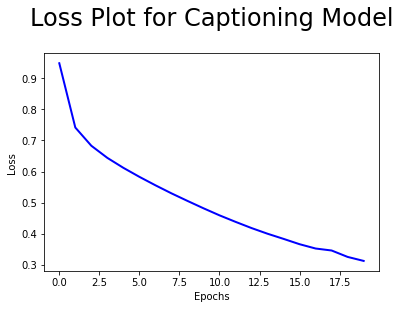

In [ ]:
plt.plot(loss_plot, c='b', lw='2')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot for Captioning Model', fontsize=24, y=1.1)
plt.savefig('lossplot.png')
plt.show()


## **Evaluating the captioning model**

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.3, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

randomid: 4593
filepath: /content/drive/MyDrive/Capstone3/train2014/COCO_train2014_000000478652.jpg


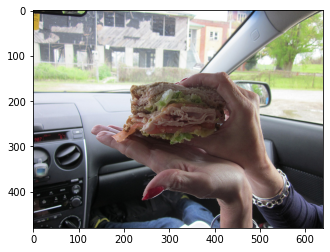

Real Caption: <start> a woman's hands holding up a sandwich in a car <end>
Prediction Caption: a person that is holding a sandwich <end>


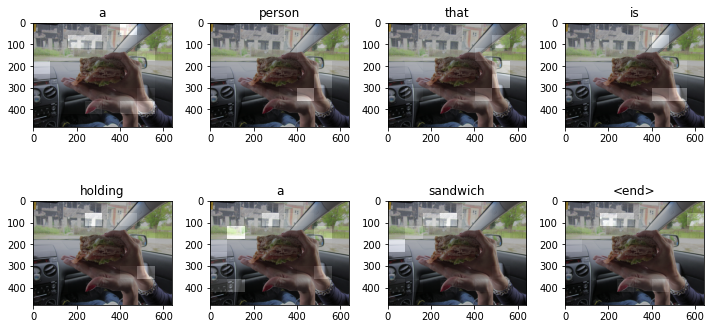

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)
print('randomid:', rid)
print('filepath:', image)
im = Image.open(image)
plt.imshow(im)
plt.show()
print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

## **Try on your own images**

Prediction Caption: a hipster cup and a watch <end>


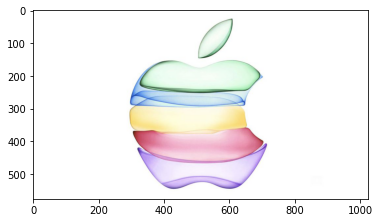

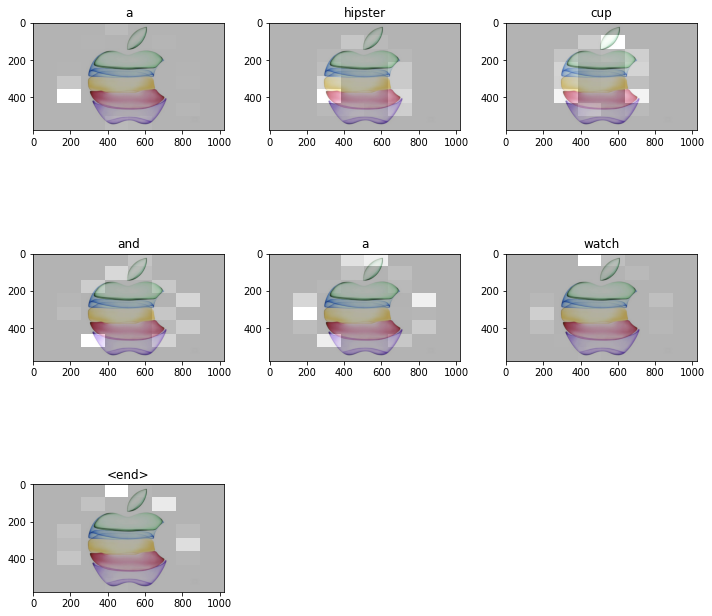

In [ ]:
#from URL
image_url = 'https://cdn.mos.cms.futurecdn.net/yJaNqkw6JPf2QuXiYobcY3-1024-80.jpg'
image_extension = image_url2[-4:]
image_path = tf.keras.utils.get_file('image17'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
im = Image.open(image_path)
plt.imshow(im)
plot_attention(image_path, result, attention_plot)

In [ ]:
#from local files

image_path = '/tmp/IMG_6332.jpg'
result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
im2 = Image.open(image_path)
plt.imshow(im2)
plot_attention(image_path, result, attention_plot)

